# *deJong 2016*  Composition-Based Descriptors

This notebook uses the composition descriptors from [deJong 2016](https://www.nature.com/articles/srep34256) to predict properties of compounds.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matminer

from pymatgen import Composition
from matminer.featurizers import composition as cp
from matminer.featurizers.data import MagpieData
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold

%matplotlib inline

## Load data
This is a dataset from OQMD, since the original deJong dataset was not provided in the paper.

In [2]:
training_file = "datasets/oqmd_all.data"

training_set = pd.read_table(training_file, sep='  ', engine='python')

#Remove known outlier
training_set = training_set.replace("None", np.nan)
min_value = min(np.array(training_set["energy_pa"], dtype=float))
training_set = training_set.replace(str(min_value), np.nan)

### Get groundstate of each compound

For compounds that appear more than once in the training set, only the lowest energy state is kept.

In [3]:
training_set['is_groundstate'] = False

In [4]:
%%time
for gid,group in training_set.groupby('comp'):
    group = group.sort_values('energy_pa', ascending=True)
    training_set.loc[group.iloc[0].name, 'is_groundstate'] = True

CPU times: user 4min 6s, sys: 1.97 s, total: 4min 8s
Wall time: 4min 12s


In [5]:
original_count = len(training_set)
training_set = training_set[training_set['is_groundstate']]
print('Removed %d/%d entries'%(original_count - len(training_set), original_count))

Removed 118653/347329 entires


## Create PyMatGen Composition objects

In [6]:
comp_objects = [Composition(comp) for comp in training_set["comp"]]
comp_objects
training_set = training_set.assign(comp_obj=comp_objects)
training_set

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,is_groundstate,comp_obj
62,Ne1,-0.02918079,21.7199,NaN,11.91,0.000137,0.00013712,True,(Ne)
65,Kr1,-0.0013236,42.8308,NaN,7.487,0.002735,0.002735225,True,(Kr)
159,B1Tc1,-7.80049421,13.1945,0.00272175,0.0,0.718864,1.10374534647,True,"(Tc, B)"
679,B1Ti1,-6.466448975,15.2648,-0.0002029,0.0,0.742588,1.5733130325,True,"(B, Ti)"
993,P1Pt1Tm1,-6.64505789667,18.5932,0.000486633333333,0.0,-1.425193,7.60066666701e-05,True,"(Tm, Pt, P)"
1007,B2Zr1,-8.29272135667,10.3174,0.000221233333333,0.0,-0.991686,4.2519999999e-05,True,"(Zr, B)"
1060,P1Pt1Tb1,-6.72520022333,19.2908,0.0004226,0.0,-1.234425,0.00012312666667,True,"(Tb, Pt, P)"
1066,H2Th1,-5.19737278,13.4329,0.0002352,0.0,-0.483323,0.0119890655755,True,"(H, Th)"
1075,Al1B2,-5.74446877667,8.51817,NaN,0.0,-0.043911,9.43066666667e-05,True,"(B, Al)"
1084,B2Mo1,-8.34425296333,8.83242,-9.54333333333e-05,0.0,-0.276247,0.15837163,True,"(Mo, B)"


## Featurize the dataset

In [7]:
%%time

def calc_attributes(training_set):
    not_attr = list(training_set) #Non-attribute columns
    
    #Statistics and attributes to compute
    stats_list = ["std_dev"]
    for pwr in range(-4,5):
        stats_list.append("holder_mean__%d"%pwr)
    attr_list = ["AtomicWeight","Number","CovalentRadius","BoilingT","Electronegativity","Column","MeltingT","Row"]
    
    training_set_updated = cp.ElementProperty(method=None, stats=stats_list, attributes=attr_list, data_source=MagpieData()).featurize_dataframe(training_set, col_id="comp_obj")
    
    all_cols = list(training_set_updated)
    attr_names = [col for col in all_cols if col not in not_attr]
    return training_set_updated, attr_names

all_descriptors, attr_names = calc_attributes(training_set)
print np.shape(all_descriptors)

/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ne. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ar. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for He. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


(228676, 89)
CPU times: user 5min 56s, sys: 1.93 s, total: 5min 58s
Wall time: 5min 59s


In [8]:
training_set_use = all_descriptors.dropna()
training_set_use

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,is_groundstate,comp_obj,holder_mean__-1 AtomicWeight,...,holder_mean__4 Number,holder_mean__4 Row,std_dev AtomicWeight,std_dev BoilingT,std_dev Column,std_dev CovalentRadius,std_dev Electronegativity,std_dev MeltingT,std_dev Number,std_dev Row
159,B1Tc1,-7.80049421,13.1945,0.00272175,0.0,0.718864,1.10374534647,True,"(Tc, B)",19.473730,...,36.160198,4.231136,43.594500,132.500000,3.000000,31.500000,0.070000,41.000000,19.000000,1.500000
679,B1Ti1,-6.466448975,15.2648,-0.0002029,0.0,0.742588,1.5733130325,True,"(B, Ti)",17.638302,...,18.512048,3.414953,18.528000,356.500000,4.500000,38.000000,0.250000,203.500000,8.500000,1.000000
993,P1Pt1Tm1,-6.64505789667,18.5932,0.000486633333333,0.0,-1.425193,7.60066666701e-05,True,"(Tm, Pt, P)",69.234734,...,66.799453,5.463481,71.994650,1447.846504,4.921608,34.393152,0.465785,765.544749,27.820855,1.414214
1007,B2Zr1,-8.29272135667,10.3174,0.000221233333333,0.0,-0.991686,4.2519999999e-05,True,"(Zr, B)",15.309341,...,30.397137,3.846901,37.907052,192.804449,4.242641,42.897811,0.334697,103.708995,16.499158,1.414214
1060,P1Pt1Tb1,-6.72520022333,19.2908,0.0004226,0.0,-1.234425,0.00012312666667,True,"(Tb, Pt, P)",68.644152,...,65.410130,5.463481,70.404567,1549.804844,4.921608,36.169355,0.484585,735.085139,27.157974,1.414214
1066,H2Th1,-5.19737278,13.4329,0.0002352,0.0,-0.483323,0.0119890655755,True,"(H, Th)",1.508633,...,68.385212,5.319957,108.908643,2391.373851,0.942809,82.495791,0.424264,947.046968,41.955002,2.828427
1084,B2Mo1,-8.34425296333,8.83242,-9.54333333333e-05,0.0,-0.276247,0.15837163,True,"(Mo, B)",15.351726,...,31.916303,3.846901,40.139624,301.227489,3.299832,32.998316,0.056569,258.329677,17.441967,1.414214
1087,Au1Si1Th1,-6.14412136333,22.4375,0.0008936,0.0,-0.775884,6.73933333329e-05,True,"(Th, Si, Au)",66.678220,...,76.842422,5.957104,89.036492,915.643793,4.642796,40.207794,0.506316,279.942148,33.536050,1.699673
1095,B2Y1,-7.17037009333,12.1023,0.000981466666667,0.0,-0.563585,3.429e-05,True,"(B, Y)",15.287044,...,29.637594,3.846901,36.814265,308.769961,4.714045,49.968879,0.386552,258.801082,16.027754,1.414214
1130,P1Pt1Y1,-7.33500527333,19.2808,0.000478433333333,0.0,-1.452008,0.00035125,True,"(P, Pt, Y)",61.653243,...,60.191642,5.082597,67.955947,1570.033280,4.921608,34.393152,0.479884,762.066887,25.961510,1.247219


## Formation Energy Prediction

In [9]:
#Energy range data
delta_e = np.array(training_set_use["delta_e"], dtype=float)

energy_range = np.zeros(np.shape(delta_e), dtype=str)
for i in range(len(delta_e)):
    if delta_e[i] < 0:
        energy_range[i] = "neg"
    else:
        energy_range[i] = "pos"
        
print energy_range

['p' 'p' 'n' ..., 'n' 'n' 'n']


In [10]:
#Classifier step
model1 = RandomForestClassifier(n_estimators=10, criterion="gini", min_samples_split=2)
model1.fit(training_set_use[attr_names], energy_range)
prediction = model1.predict(training_set_use[attr_names])

In [11]:
pd.crosstab(energy_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,n,p
actual,,
n,29895,97
p,274,83515


### Regressor Step

In [12]:
rf_model = RandomForestRegressor()
rf_model.fit(training_set_use[attr_names], delta_e)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [13]:
prediction = rf_model.predict(training_set_use[attr_names])

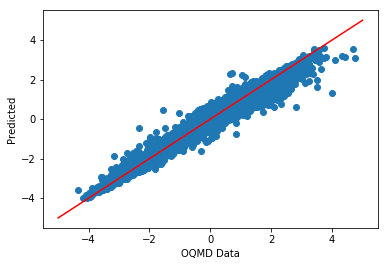

In [14]:
plt.scatter(delta_e, prediction)
plt.plot(range(-5,6), range(-5,6), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

### Compute cross-validation error

In [15]:
%%time

errors = cross_val_score(RandomForestRegressor(), training_set_use[attr_names], delta_e, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.245055296152
CPU times: user 13min 38s, sys: 2.28 s, total: 13min 40s
Wall time: 13min 43s
